In [2]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra
using Printf
import ForwardDiff as FD
using JuMP
using COSMO

  Activating environment at `~/SSD/Code/TinyMPC/julia/cone_simple/Project.toml`


In [89]:
# -------------------THIS IS ALL ALTRO-------------------------------
# This enables goal equality constraints, state and input ineq constraints.

function stage_cost(p::NamedTuple,x,u,k)
    dx = x - p.Xref[k]
    du = u - p.Uref[k]
    return 0.5*dx'*p.Q*dx + 0.5*du'*p.R*du
end
function term_cost(p::NamedTuple,x)
    dx = x - p.Xref[p.N]
    return 0.5*dx'*p.Qf*dx
end
function stage_cost_expansion(p::NamedTuple,k)
    dx = - p.Xref[k]
    du = - p.Uref[k]
    return p.Q, p.Q*dx, p.R, p.R*du  # Hessian and gradient
end
function term_cost_expansion(p::NamedTuple)
    dx = - p.Xref[p.N]
    return p.Qf, p.Qf*dx
end
function conic_cost_expansion(p::NamedTuple, u, λc, ρ, k)
    λhat = λc # already updated
    ∇c = cone_u_jac(p, u)
    G = ∇c'*∇projection(λhat)*projection(λhat) 
    H = ∇c'*∇projection(λhat)'*∇projection(λhat)*∇c*ρ
    # display(∇projection(λhat)')
    # H = zeros(p.ncu_cone,p.ncu_cone)
    return (G - H*u), H
end
function backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
    """iLQR backward pass with AL. This !function update its parameters
    """
    N = params.N
    ΔJ = 0.0    # expected cost reduction

    # terminal cost expansion
    P[N], p[N] = term_cost_expansion(params) 
    
    if (params.ncx > 0)
        # # add AL terms for the state constraint at the final time step
        hxv = ineq_con_x(params,X[N])  # h(x) violation  
        mask = eval_mask(μx[N],hxv)
        ∇hx = ineq_con_x_jac(params,X[N])
        # add these into the cost-to-go p and P
        p[N]  += ∇hx'*(μx[N] - ρ*(mask * [params.x_max;-params.x_min]))  # multiplier term (1st)
        P[N]  += ρ*∇hx'*mask*∇hx                # penalty term (2nd)
    end
    
    if (params.ncg > 0)
        # add AL terms for goal constraint 
        ∇hx = diagm(ones(params.nx))
        # add these into the CTG p and P (equality active)
        p[N]  += ∇hx'*(λ - ρ*params.Xref[N])   
        P[N]  += ρ*∇hx'∇hx
    end
    
    # iterate from N-1 to 1 backwards
    for k = (N-1):(-1):1
        # dynamics jacobians (linearization about previous iterate)
        A = FD.jacobian(_x -> discrete_dynamics(params,_x,U[k],k),X[k])
        B = FD.jacobian(_u -> discrete_dynamics(params,X[k],_u,k),U[k])

        Sxx,Sx,Suu,Su = stage_cost_expansion(params,k)
        
        # one-step cost expansion: Q, Q*dx, R, R*du
        Sx += A' * (P[k+1]*f + p[k+1]) 
        Su += B' * (P[k+1]*f + p[k+1]) 
        Sxx += A'*(P[k+1])*A
        Suu += B'*(P[k+1] + reg*I)*B                                     
        Sux = B'*(P[k+1])*A  
        if (params.ncu > 0)
            # control constraints
            huv = ineq_con_u(params,U[k])  # calculate h(u) constraint
            mask = eval_mask(μ[k],huv)  # choose active
            ∇hu = ineq_con_u_jac(params,U[k])
            Su  += ∇hu'*(μ[k] - ρ*(mask * [params.u_max;-params.u_min])) # add to cost
            Suu += ρ*∇hu'*mask*∇hu
        end
        if (params.ncx > 0)
            # state constraints
            hxv = ineq_con_x(params,X[k])
            mask = eval_mask(μx[k],hxv)
            ∇hx = ineq_con_x_jac(params,X[k])
            Sx  += ∇hx'*(μx[k] - ρ*(mask * [params.x_max;-params.x_min]))
            Sxx += ρ*∇hx'*mask*∇hx
        end
        if (params.ncu_cone > 0)
            # conic constraints
            Qu, Quu = conic_cost_expansion(params, U[k], λc[k], ρ/cone_scale, k)
            # display(Quu)
            Su += Qu
            Suu += Quu
        end
        
        # Calculate Gains
        F = cholesky(Symmetric(Suu))
        d[k] = F\Su
        K[k] = F\Sux

        # Cost-to-go Recurrence (PSD stabilizing version, last term)
        P[k] = Sxx + K[k]'*Suu*K[k] - 2*K[k]'*Sux
        p[k] = Sx + K[k]'*Suu*d[k] - K[k]'*Su - Sux'*d[k]
        ΔJ += Su'*d[k]
    end

    return ΔJ  # but also change params
end
function forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ; 
                        max_linesearch_iters = 20)
    """iLQR forward pass and line-search
    This !function update its parameters
    """
    N = params.N
        # Forward Rollout
        for k = 1:(N-1)
            Un[k] = - d[k] - K[k]*Xn[k] 
            Xn[k+1] = discrete_dynamics(params,Xn[k],Un[k],k)
        end
    X .= Xn
    U .= Un
    return 0, 0
end
function eval_mask(μv,huv)  
    # Extract active inequality constraints
    # active set mask
    mask = Diagonal(zeros(length(huv)))
    for i = 1:length(huv)
        mask[i,i] = (μv[i] > 0 || huv[i] > 0)
    end
    mask
end
function mpc(params,X,U,P,p,K,d,Xn,Un;atol=1e-3,max_iters = 250,verbose = true,ρ=1,ϕ=10)

    # first check the sizes of everything
    # @assert length(X) == params.N
    # @assert length(U) == params.N-1
    # @assert length(X[1]) == params.nx
    # @assert length(U[1]) == params.nu

    # keep track of trajectories for each iterate
    Xh=[deepcopy(X) for i = 1:1000]

    # initial rollout
    N = params.N
    for i = 1:N-1
        X[i+1] = discrete_dynamics(params,X[i],U[i],i)
    end

    Xh[1] .= X

    reg_min = 1e-8
    reg = reg_min

    μ = [zeros(params.ncu) for i = 1:N-1]   # input constraints

    μx = [zeros(params.ncx) for i = 1:N]    # state constraints

    λ = zeros(params.nx)    # goal constraint

    λc = [zeros(params.ncu_cone) for i = 1:N-1]   # goal constraint
    
    # Inner loop to solve unconstrained problem (Riccati)
    for iter = 1:max_iters
        J = 0.0
        ΔJ = 0.0
        α = 1.0
        for i = 1:5
            ΔJ = backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
            J, α = forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ)
        end

        Xh[iter + 1] .= X  
        if verbose
            if rem(iter-1,10)==0
                @printf "iter     J           ΔJ        |d|         α        reg         ρ\n"
                @printf "---------------------------------------------------------------------\n"
            end
            @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f   %9.2e   %9.2e\n",
              iter, J, ΔJ, 0, α, reg, ρ)
        end
        # update multipliers and check constraint violation, max of all
        convio = 0  
        
        if (params.ncu > 0)
            # control constraints (inequality)
            for k = 1:N-1
                huv = ineq_con_u(params,U[k])
                mask = eval_mask(μ[k],huv)
                # update dual
                convio = max(convio,norm(huv + abs.(huv),Inf))
                μ[k] = max.(0,μ[k] - ρ*(mask * [params.u_max;-params.u_min]))
                
            end
        end
        if (params.ncx > 0)
            # state constraints (inequality)
            for k = 1:N
                hxv = ineq_con_x(params,X[k])
                mask = eval_mask(μx[k],hxv)
                # update dual
                convio = max(convio,norm(hxv + abs.(hxv),Inf))
                μx[k] = max.(0,μx[k] - ρ*(mask * [params.x_max;-params.x_min]))                
            end
        end
        if (params.ncu_cone > 0)
            # conic constraints 
            if verbose
                print("update cone\n")
            end            
            for k = 1:N-1
                # update dual
                Uc = cone_u(params, U[k])
                huc = norm(Uc[1:2]) - Uc[3]
                convio = max(convio, norm(huc + abs.(huc),Inf))
                λc[k] = projection(λc[k] + ρ*Uc/cone_scale)
                # display(λc[k])
            end
        end
        if (params.ncg > 0)
            # goal constraint (equality)
            hxv = X[N] - params.Xref[N]
            λ .-= ρ*params.Xref[N]
            convio = max(convio, norm(hxv,Inf))
        end
        if verbose
            @show convio
        end
        if convio <1e-4  # if terminal condition with contraint violation
            # @info "success!"
            return Xh[1:(iter + 1)];
        end

        ρ *= ϕ  # update penalty
    end
    print("Our solver says INFEASIBLE\n")
    return Xh[1:(max_iters + 1)]
end
#----------------------ALTRO DONE --------------------------

mpc (generic function with 1 method)

In [10]:
# =============================
# Example problem formulation and solve
# =============================

# ---------------------THIS IS WHAT YOU NEED TO INPUT--------
A = [1.0 0.0 0.0 0.05 0.0 0.0; 
    0.0 1.0 0.0 0.0 0.05 0.0; 
    0.0 0.0 1.0 0.0 0.0 0.05; 
    0.0 0.0 0.0 1.0 0.0 0.0; 
    0.0 0.0 0.0 0.0 1.0 0.0; 
    0.0 0.0 0.0 0.0 0.0 1.0]
B = [0.000125 0.0 0.0; 
    0.0 0.000125 0.0;
    0.0 0.0 0.000125; 
    0.005 0.0 0.0; 
    0.0 0.005 0.0; 
    0.0 0.0 0.005]
f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
function discrete_dynamics(p::NamedTuple,x,u,k)
    A = [1.0 0.0 0.0 0.05 0.0 0.0; 
        0.0 1.0 0.0 0.0 0.05 0.0; 
        0.0 0.0 1.0 0.0 0.0 0.05; 
        0.0 0.0 0.0 1.0 0.0 0.0; 
        0.0 0.0 0.0 0.0 1.0 0.0; 
        0.0 0.0 0.0 0.0 0.0 1.0]
    B = [0.000125 0.0 0.0; 
        0.0 0.000125 0.0;
        0.0 0.0 0.000125; 
        0.005 0.0 0.0; 
        0.0 0.005 0.0; 
        0.0 0.0 0.005]
    f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
    return A*x + B*u + f
end
function ineq_con_x(p,x)
    [x-p.x_max;-x + p.x_min]
end
function ineq_con_u(p,u)
    [u-p.u_max;-u + p.u_min]
end
function cone_u(p, u)
    [p.A_cone*u;p.c_cone'*u]
end
function cone_u_jac(p, u)
    J = zeros(p.nu, p.nu)
    J[1:end-1,1:end] .= p.A_cone
    J[end,1:end] .= p.c_cone
    return J
end
function ineq_con_u_jac(params,u)
    FD.jacobian(_u -> ineq_con_u(params,_u), u)
end
function ineq_con_x_jac(p,x)
    FD.jacobian(_x -> ineq_con_x(p,_x),x)
end
function projection(x)
    n = length(x)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s  # below the cone
        return zero(x)
    elseif a <= s  # in the code
        return x
    elseif a >= abs(s)  # outside the cone
        return 0.5 * (1 + s/a) * [v; a] 
    end
end
function ∇projection(x)
    n = length(x)
    J = zeros(eltype(x),n,n)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s
        return J  # zeros
    elseif a <= s
        J .= I(n)  
        return J  # identity
    elseif a >= abs(s)
        c = 0.5 * (1 + s/a)

        # dvdv ok!
        for i = 1:n-1, j = 1:n-1
            J[i,j] = -0.5*s/a^3 * v[i] * v[j]
            if i == j
                J[i,j] += c
            end
        end

        # dvds ok!
        for i = 1:n-1
            J[i,n] = 0.5 * v[i] / a
        end

        # dsdv ok!
        for i = 1:n-1
            J[n,i] = ((-0.5*s/a^2) + c/a) * v[i]
        end
        J[n,n] = 0.5  # ok
        return J
    else
        error("Invalid second-order cone projection.")
    end
    return J
end

∇projection (generic function with 1 method)

iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    0.000e+00   3.56e+06   0.00e+00  0.0000    1.00e-08    1.00e+00
update cone
convio = 29.899759669898994
  2    0.000e+00   3.60e+06   0.00e+00  0.0000    1.00e-08    1.00e+01
update cone
convio = 29.331963838841656
  3    0.000e+00   3.82e+06   0.00e+00  0.0000    1.00e-08    1.00e+02
update cone
convio = 25.162045739538954
  4    0.000e+00   3.74e+06   0.00e+00  0.0000    1.00e-08    1.00e+03
update cone
convio = 11.435868742049452
  5    0.000e+00   3.19e+06   0.00e+00  0.0000    1.00e-08    1.00e+04
update cone
convio = 1.8073407548466673
  6    0.000e+00   3.08e+06   0.00e+00  0.0000    1.00e-08    1.00e+05
update cone
convio = 1.4518732082157513
  7    0.000e+00   3.33e+06   0.00e+00  0.0000    1.00e-08    1.00e+06
update cone
convio = 1.3990380582830682
  8    0.000e+00   5.74e+06   0.00e+00  0.0000    1.00e-08    1.00e+07
update cone
conv

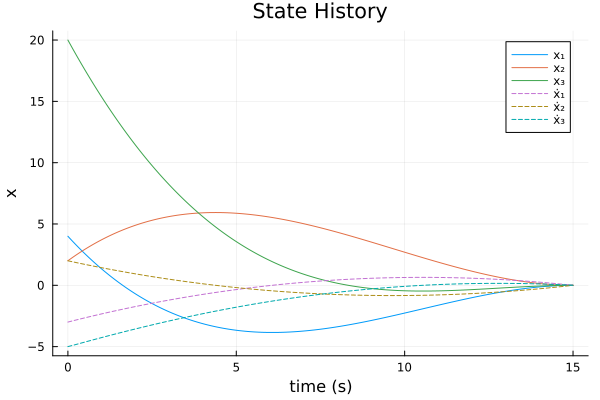

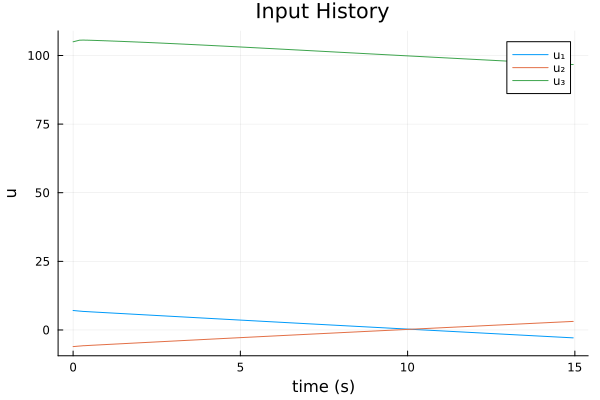

In [24]:
# Let's solve

nx = 6
nu = 3
N = 301
dt = 0.05
t_vec = dt*(0:N-1)
x0 = [4, 2, 20, -3, 2, -5.0]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

Q = 1e-1*Diagonal([1,1,1,1.0,1,1])
R = 1e-0*Diagonal([1,1,1])
Qf = 1000*Q

# ground_level = 0.0
gravity = [0; 0; -9.81]
mass = 10.0
# ωPlanet = [0.0; 0.0; 0.0]
perWeightMax = 2.0
θ_thrust_max = 5.0  # deg
# θ_glideslope = 60.0 # deg
# glide_recover_k = 8

A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]
u_bnd = mass * abs(gravity[3]) * perWeightMax
u_min = -170*ones(nu)
u_max =  170*ones(nu)

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 1
ncu_cone = nu*1; 
cone_scale = 1000000  # very fragile for each problem

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [mass * gravity for k = 1:N-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
Xhist = mpc(params,X,U,P,p,K,d,Xn,Un;atol=1e-1,max_iters = 10,verbose = true,ρ = 1e0, ϕ = 10.0);
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
using Plots
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))

For TrajOpt, it needs more tricks to get better results:
- Hessian of the projection => better approximation
- Scaling between conic constraints and other ones
- Solution polishing

In [25]:
# Check conic violation
convio = 0.0
for k = 1:N-1
    Uc = cone_u(params, U[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end
Xref .= Xn;
Uref .= Un;

0.14717004982271042

0.05520615451097122

-0.03670047929689346

-0.12854841258692673

-0.21729734877786555

-0.27727737136373243

-0.37737450859179766

-0.39654031686875335

-0.4502260845868804

-0.4983238008806925

-0.5464947005737155

-0.5946369656456785

-0.6400664737417667

-0.6845918820419516

-0.7290923054979874

-0.773567674958743

-0.8180179242029091

-0.8624429899067305

-0.9068428116117939

-0.9512173316927512

-0.9955664953251873

-1.039890250452963

-1.0841885477560904

-1.1284613406180846

-1.1727085850934955

-1.216930239875385

-1.2611262662625267

-1.3052966281267464

-1.3494412918798853

-1.393560226440937

-1.4376534032030008

-1.4817207959999834

-1.5257623810732985

-1.5697781370383632

-1.6137680448508833

-1.6577320877732165

-1.7016702513401238

-1.7455825233248925

-1.7894688937046794

-1.8333293546260974

-1.8771639003703147

-1.9209725273179368

-1.964755233913773

-2.0085120206311586

-2.052242889936049

-2.0959478462507732

-2.1396268959176066

-2.183280047161662

-2.226907310053802

-2.270508696472887

-2.3140842200676834

-2.3576338962182835

-2.4011577419972934

-2.4446557761301184

-2.488128018955072

-2.531574492382756

-2.5749952198549613

-2.618390226302889

-2.661759538104665

-2.705103183042307

-2.7484211902578073

-2.791713590208647

-2.8349804146222306

-2.8782216964496827

-2.9214374698186703

-2.9646277699852783

-3.0077926332847094

-3.050932097081205

-3.094046199716689

-3.137134980458094

-3.1801984794436056

-3.2232367376275626

-3.2662497967237734

-3.3092376991476273

-3.352200487956207

-3.3951382067872045

-3.4380508997957353

-3.480938611589327

-3.5238013871611855

-3.5666392718208346

-3.609452311123171

-3.6522405507946463

-3.6950040366571963

-3.7377428145494784

-3.780456930245238

-3.8231464293688546

-3.865811357307418

-3.908451759119842

-3.951067679441995

-3.9936591623883846

-4.03622625144951

-4.078768989385236

-4.121287418113202

-4.163781578592814

-4.206251510703638

-4.248697253118535

-4.291118843170921

-4.333516316715478

-4.375889707982508

-4.418239049424906

-4.460564371557563

-4.502865702788534

-4.545143069241633

-4.587396494569434

-4.629625999756468

-4.671831602911517

-4.714013319048567

-4.756171159855189

-4.7983051334479345

-4.840415244113213

-4.8825014920331515

-4.924563872994549

-4.966602378080681

-5.008616993343383

-5.050607699455041

-5.0925744713379375

-5.134517277769929

-5.1764360809638

-5.218330836118983

-5.260201490942485

-5.302047985137062

-5.3438702498536825

-5.38566820710517

-5.427441769137672

-5.469190837756381

-5.510915303601305

-5.552615045368711

-5.594289928973151

-5.635939806644956

-5.677564515956563

-5.719163878771649

-5.760737700109173

-5.802285766914339

-5.843807846727161

-5.885303686238718

-5.926773009723263

-5.9682155173339275

-6.009630883247741

-6.051018753643849

-6.0923787444972515

-6.133710439168246

-6.175013385764583

-6.216287094251313

-6.257531033279484

-6.29874462670117

-6.33992724973428

-6.381078224735139

-6.422196816531405

-6.46328222726136

-6.5043335906574455

-6.5453499657033145

-6.586330329583401

-6.627273569831269

-6.668178475569313

-6.709043727715535

-6.74986788801332

-6.790649386717107

-6.831386508739428

-6.872077378032407

-6.912719939937794

-6.953311941193817

-6.9938509072318755

-7.034334116329448

-7.074758570105984

-7.115120959752002

-7.155417627263942

-7.195644520815154

-7.235797143218817

-7.275870492224659

-7.315858991128465

-7.35575640784781

-7.395555760214092

-7.435249204728909

-7.474827905403965

-7.514281878516966

-7.55359980812212

-7.592768825901044

-7.631774247348465

-7.670599254265949

-7.7092245109597535

-7.747627698250712

-7.785782945206073

-7.8236601331521545

-7.861224039731191

-7.8984332821983285

-7.9352390084943

-7.9715832716440795

-8.007397007792736

-8.04259752145661

-8.077085365568252

-8.110740493718932

-8.143417568071921

-8.174940348503817

-8.20509520168473

-8.233624010354493

-8.260217216027923

-8.284508487764118

-8.306073621538006

-8.32443758352307

-8.339094498304894

-8.349544554445442

-8.355347623915515

-8.356185465497466

-8.351915833880453

-8.342599289040026

-8.328487826374626

-8.30998002484255

-8.287559781434249

-8.261737521246888

-8.23300586146088

-8.201812875452491

-8.168550242717531

-8.133551516596324

-8.097096107750739

-8.059415828488763

-8.020702078515457

-7.981112662527983

-7.940777801297857

-7.899805216875149

-7.858284331062254

-7.816289682694752

-7.773883687178137

-7.731118856551473

-7.688039583832873

-7.644683578500738

-7.601083023882405

-7.557265513208744

-7.513254809438861

-7.469071464525955

-7.424733326278358

-7.380255955035539

-7.3356529677214235

-7.290936323184558

-7.2461165598759845

-7.201202994673279

-7.1562038898973945

-7.111126594182322

-7.065977661760072

-7.020762953855914

-6.975487725195895

-6.930156698077431

-6.884774126010372

-6.8393438485798566

-6.793869338894522

-6.748353744749581

-6.702799924444937

-6.657210478042139

-6.611587774718408

-6.565933976768464

-6.520251060720841

-6.474540835962167

-6.428804961203369

-6.383044959072263

-6.337262229075496

-6.2914580591367395

-6.245633635890263

-6.199790053882684

-6.153928323815247

-6.108049379941136

-6.06215408671704

-6.016243244794833

-5.970317596428954

-5.92437783036422

-5.878424586262346

-5.832458458716177

-5.786480000897104

-5.740489727873218

-5.694488119633114

-5.648475623845691

-5.602452658381994

-5.556419613623509

-5.510376854577732

-5.464324722819473

-5.418263538275048

-5.372193600863886

-5.326115192010995

-5.280028576042202

-5.233934001472902

-5.187831702199569

-5.141721898603253

-5.095604798572163

-5.0494805984507565

-5.003349483921383

-4.9572116308246565

-4.9110672059227145

-4.864916367611357

-4.818759266584024

-4.772596046452723

-4.726426844327921

-4.680251791362156

-4.6340710132588026

-4.587884630750009

-4.541692760045112

-4.495495513251984

-4.449292998774149

-4.4030853216841965

-4.356872584076256

-4.310654885398562

-4.264432322767537

-4.2182049912685375

In [27]:
### MPC style ###
Nsim = 301
Nh = 21
t_vec = dt*(0:Nsim-1)

x0 = [4, 2, 20, -3, 2, -5.0]  # initial plan
# x0 = [5, 2, 21, -3, 2, -5.0]  # change this!
# x0 = [4.4, 2.2, 20.2, -3.03, 2.02, -5.05]

xg = [0,0,0,0,0,0.0]
Q = 10e-1*Diagonal([1,1,1,1.0,1,1])  # make this higher!
R = 1e-1*Diagonal([1,1,1])
Qf = 100*Q  # change this!
θ_thrust_max = 7.0  # increase max thrust from plan!

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 0
ncu_cone = nu*1; 
cone_scale = 1

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = Nh,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

Xhist = [deepcopy(x0) for i = 1:Nsim]
Uhist = [-mass * gravity for k = 1:Nsim-1]
# previous iterate
X = [deepcopy(x0) for i = 1:Nh]
U = [-mass * gravity for k = 1:Nh-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:Nh]   # cost to go quadratic term
p = [zeros(nx) for i = 1:Nh]      # cost to go linear term
d = [zeros(nu) for i = 1:Nh-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:Nh-1] # feedback gain

for i = 1:Nsim-Nh-1
    params1 = (; params..., Uref = Uref[i:Nh+i], Xref = Xref[i:Nh+i-1])  # update ref
    
    # noise_pos = randn(3)
    # noise_vel = randn(3)
    # pos_norm = norm(Xhist[i][1:3], Inf) / 100 # 1% noise
    # vel_norm = norm(x0[4:6], Inf) / 1e6 # 1ppm noise
    # Xhist[i] += [noise_pos * pos_norm; noise_vel * vel_norm]
    X[1] .= Xhist[i]  # update initial
    X_ = mpc(params1,X,U,P,p,K,d,Xn,Un;atol=1e-1,max_iters = 15,verbose = false,ρ = 1e0, ϕ = 10.0);
    Uhist[i] = Un[1]
    Xhist[i+1] = discrete_dynamics(params1,Xhist[i],Uhist[i],i)  # dynamics
end

In [90]:
### MPC style with other solver ###
include("mpc_JuMP.jl")
Nsim = 301
Nh = 21
t_vec = dt*(0:Nsim-1)

x0 = [4, 2, 20, -3, 2, -5.0]  # initial plan
# x0 = [5, 2, 21, -3, 2, -5.0]  # change this!
# x0 = [4.4, 2.2, 20.2, -3.03, 2.02, -5.05]

xg = [0,0,0,0,0,0.0]
Q = 10e-1*Diagonal([1,1,1,1.0,1,1])  # make this higher!
R = 1e-1*Diagonal([1,1,1])
Qf = 100*Q  # change this!
θ_thrust_max = 7.0  # increase max thrust from plan!

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 0
ncu_cone = nu*1; 
cone_scale = 1

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = Nh,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

Xhist = [deepcopy(x0) for i = 1:Nsim]
Uhist = [-mass * gravity for k = 1:Nsim-1]
# previous iterate
X = [deepcopy(x0) for i = 1:Nh]
U = [-mass * gravity for k = 1:Nh-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:Nh]   # cost to go quadratic term
p = [zeros(nx) for i = 1:Nh]      # cost to go linear term
d = [zeros(nu) for i = 1:Nh-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:Nh-1] # feedback gain

optimizer = JuMP.optimizer_with_attributes(COSMO.Optimizer,
    "verbose"=>false,
    "eps_abs"=>1e-4,
    "eps_rel"=>1e-4,
    "rho"=>1e-2,
    "scaling"=>0,
    "alpha"=>1.0)

for i = 1:Nsim-Nh-1
    params1 = (; params..., Uref = Uref[i:Nh+i], Xref = Xref[i:Nh+i-1])  # update ref
    noise_pos = randn(3)
    noise_vel = randn(3)
    pos_norm = norm(Xhist[i][1:3], Inf) / 100 # 1% noise
    vel_norm = norm(x0[4:6], Inf) / 1e6 # 1ppm noise
    Xhist[i] += [noise_pos * pos_norm; noise_vel * vel_norm]
    
    # Uhist[i] = mpc_JuMP(optimizer, params1, Xhist[i], A, B, f)
    X_ = mpc(params1,X,U,P,p,K,d,Xn,Un;atol=1e-1,max_iters = 15,verbose = false,ρ = 1e0, ϕ = 10.0); Uhist[i] = Un[1]
    Xhist[i+1] = discrete_dynamics(params1,Xhist[i],Uhist[i],i)  # dynamics
end

LoadError: MethodError: [0mCannot `convert` an object of type [92mDiagonal{Float64, Vector{Float64}}[39m[0m to an object of type [91mFloat64[39m
[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::Gray24[39m) where T<:Real at /home/khai/.julia/packages/ColorTypes/1dGw6/src/conversions.jl:114
[0m  convert(::Type{T}, [91m::Gray[39m) where T<:Real at /home/khai/.julia/packages/ColorTypes/1dGw6/src/conversions.jl:113
[0m  convert(::Type{T}, [91m::Base.TwicePrecision[39m) where T<:Number at twiceprecision.jl:250
[0m  ...

In [84]:
# Check conic violation
convio = 0.0
for k = 1:Nsim-1
    Uc = cone_u(params, Uhist[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end

-0.00045963710848440087

-4.1854269547059175e-5

-0.0004913338739243045

-0.0004844058307957866

1.1223172318608476e-5

0.001667442783023887

0.00018753595087073194

-0.00047616872055833426

-0.001455315247094191

6.258599016994992e-5

-0.00038555714473176295

-0.0009696152151459358

1.9449349242250946e-6

-0.003069520134742376

-0.00031428535155697546

-0.00011685870280331301

-0.0002063710218376258

0.00040859008099047855

-0.00041743472477584476

-0.0007099698411057176

-0.00027291637296755766

7.803284615803818e-6

-0.0017236929062471873

0.001004723832220833

-0.0016899630901434648

-0.0001981287360228734

0.0008606222075489001

-0.0008956177686965106

0.00019542109911796501

-0.00035811147758479933

-0.00011040415624918865

-0.0003681472465864033

3.8889896815774705e-5

-0.00031391697538296626

0.0003483360057927598

9.415445742799733e-5

-0.0019498309844809825

-7.220995622869708e-5

-2.3113772341432082e-5

-0.00018836650225573237

-2.3730871068767527

-3.9524573742473867

-8.577296964418224e-5

0.0021967482857103704

-3.09371640287992e-5

-7.212942596801497e-5

0.001111222780077803

-0.0004858384167008012

-0.000494963798752579

6.912198775310685e-5

0.0008260640281880782

0.0009511724919253339

-0.00042262548366345243

0.0007137326934838484

-0.002263679900414317

-0.0012144667786788688

0.0016469906868188389

-1.5517067827567566

-0.0009442661127572194

-0.0005524577688724719

-0.0002518641995257198

0.00019634686163882975

-0.0018085756748149606

0.00011607915744349384

-0.001993704342243774

-0.00012615420418882195

0.00023720276903205217

0.0001366868804097976

0.0008256861368565183

0.001006380223655512

0.0011844146320463267

6.102175574973501e-5

-4.5937334105516925e-5

-1.6408431242692076

-2.78851102375246

0.000711612279386209

-0.5198508714239622

-0.00011180324775850181

-8.10588395783185e-6

-0.028913474149350193

1.9249595769821326e-5

3.6580515929252044e-5

-0.0014923338153263188

-0.001363542040300203

-3.696431652472329

-5.581236635566872

-3.634842487648385

-4.512063037038578

-1.3189217136561027

-5.9217132469659575

-8.057400439087543

-0.8030795538751363

-1.531969342796101

-4.747239896038233

-0.03915162387967541

-2.314362373805433

-3.6775394221422175e-5

-4.148418475039984

-5.683799505973648

-4.192120753061286

-0.04906085137796001

-6.276925605419592e-5

0.0017284876317589237

-0.19694221931734468

-0.002243628584357893

-1.874734404049292

-2.475351559675964

-4.821138941413862

-7.021575273315481

-4.590771630852312

-7.167985137172385

-3.6472017080118277

-7.91989622920423

-4.212487742525051

-0.7929713201587205

-6.70477269126475

-4.71462109449242

-6.023539376544688

-7.7876188328891764

-5.435175037017362

-3.8450520290793175

-4.109417847217264

-4.7755006757198935

-2.8776401610451936

-4.714968433207647

-3.6424719793915514

-0.24061422083130424

-4.3765634739136825

-6.972295645064614

-4.168932752571022

-4.2838847422932185

-2.703398308691485

-4.5622869314470496

-4.785847225573271

-6.01244570688414

-2.548935642092725

-6.4414526024087815

-4.036898695621207

-4.600958174788406

-5.6306157903902525

-5.9275289759526935

-3.90361727560846

-2.699914781570791

-6.776748421295148

-6.301762922002196

-2.9273121898738816

-1.7692464942056851

-0.0003549011368555455

0.0005781025615334556

-0.00023263872435208555

4.28240755656617e-5

-2.08851859895276e-6

0.0012205247365999483

-3.4191261036653486e-5

-1.1693550400564066

-1.0968331703634728

-2.311198446638338

0.00110881881093583

-3.397401229010244

-8.28810700978541

-5.650265136416998

-0.918063131975261

-4.055425807829936

-1.6804710889524301

-0.08505611487816367

-1.887926539067525

-6.44956588714775

-6.8003398816427145

-2.1814850411743727

-1.9703049049285095

-3.8298679605221393

-5.5044362517852505

-2.99796482275183

-8.30818614640808

-5.205239927990041

-3.2168952386190828

-6.380464626221608

-3.507763578833778

-7.1743757713552245

-3.7477053086855188

-0.00019364102315044818

-1.8277711679953086

-2.103205511984176

-4.249238679663856

-0.0009354905778771183

-0.0005035106424298164

-1.163882633963338

-4.441452225228967

-6.548537760699459

-6.634704588964513

-6.039928684770946

-2.43360227773516

-0.3169202550840069

-2.122381843795428

-0.029849311615440577

-3.479477967854291

-6.797965447524829

-3.1306274197050694

-5.22363526798852

-7.277090058465638

-3.9637835253479246

-3.9987083659745486

-6.6924827777580225

-4.647186728577791

-5.156555572615434

-4.586824678178305

-3.8337848135940362

-4.832070137997388

-4.54012966822347

-4.103181488190772

-6.706516297454416

-7.535369113850211

-5.928074190045487

-5.8507216443849455

-6.449406937944366

-7.438069232614195

-6.822485794160476

-5.106032192110106

-6.955892838139561

-8.347194859845482

-5.262288267934412

-4.853552553429841

-6.994208105924448

-5.11880281351881

-6.841144769000403

-6.531548381945607

-6.935903517074243

-7.06907078946435

-5.7308330722730645

-5.781381709113529

-5.94396952635485

-4.038847963811842

-4.389663488258786

-2.9149291904837638

-0.00017898937251992209

-7.592852241755416

-6.997178369545204

-4.706767551160154

-7.431682806444128

-7.508212827446817

-6.093974074989008

-5.654783318159462

-5.377100249896905

-6.643827245726829

-7.652122948098291

-5.217901005330563

-6.730602198040428

-7.507688833349051

-6.335158203488437

-5.84863730842497

-4.580561940205735

-4.997196704249392

-6.43020850950672

-5.497826989630616

-7.351294346909088

-7.273477536866167

-7.177556480652209

-6.083868500441709

-5.24783969751495

-5.7079091907169115

-6.0371947334656255

-5.63460991323066

-5.2949551127006576

-5.6891571853374865

-5.555494630766255

-5.351155500822497

-5.594001587949371

-5.789328060965293

-6.183576299689852

-5.283847134058172

-5.620622225474792

-5.279682862898277

-5.463453084492406

-5.718165084875663

-5.350383340017908

-6.195694907799468

-4.97606703530688

-5.74039295563976

-4.939310346149593

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

-8.582637891893146

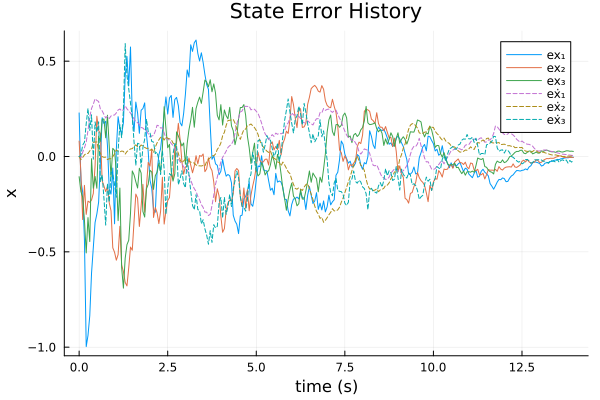

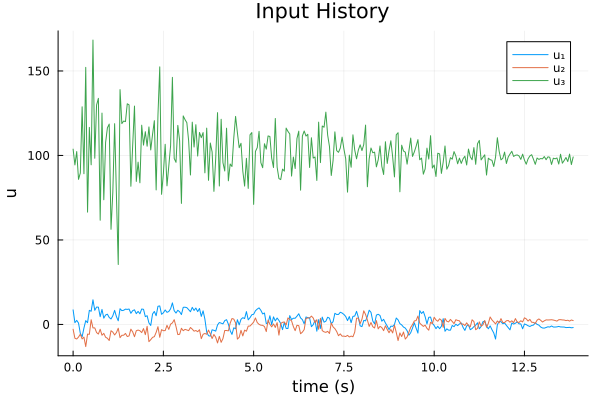

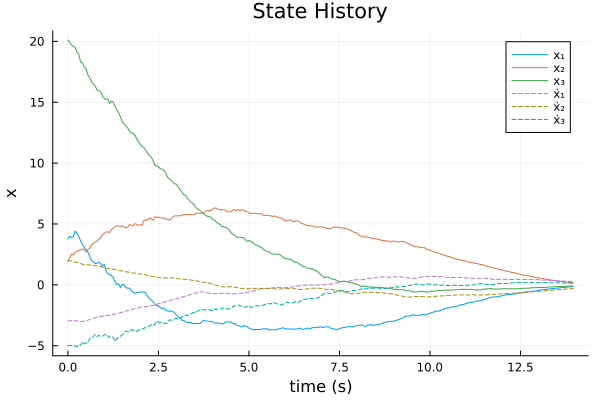

In [85]:
Xsim_m = mat_from_vec(Xhist[1:end-Nh])
Usim_m = mat_from_vec(Uhist[1:end-Nh-1])
e_sim_m = mat_from_vec(Xref[1:end-Nh]-Xhist[1:end-Nh])
display(plot(t_vec[1:end-Nh],e_sim_m',label = ["ex₁" "ex₂" "ex₃" "eẋ₁" "eẋ₂" "eẋ₃"], linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State Error History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-Nh-2],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))
display(plot(t_vec[1:end-Nh],Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"], linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))